In [1]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

# To import 'katakana' from relative path
sys.path.append(os.path.abspath(os.path.join('..')))
from katakana import encoding

INPUT_LENGTH = 22
OUTPUT_LENGTH = 22


Using TensorFlow backend.


# Data pre-processing

In [2]:
with open('../data/dataset_random.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

data_input=[]
data_output=[]
        
for line in lines:
    input_text, target_text = line.split(' ')
    #if(len(input_text)>20 and len(target_text)>20):
     #   print(input_text+" "+target_text)
    data_input.append(input_text)
    data_output.append(target_text)
    
print(data_input[1],data_output[1])    

রাজ্যগুলোর রাজ্য


In [3]:
#data = pd.read_csv('../data/joined_titles.csv', header=None)
#data = data.sample(frac=1, random_state=0)

########################data_input = [s.decode('utf-8').lower() for s in data[0]]
########################data_output = [s.decode('utf-8') for s in data[1]]

#data_input = [s.lower() for s in data[0]]
#data_output = [s for s in data[1]]

#print(data_input[0], data_output[0])
#print(data_input[5], data_output[5])


data_size = len(data_input)

# We will use the first 0-60th %-tile (60%) of data for the training
training_input  = data_input[int(data_size*0/100):int(data_size*80/100)]
training_output = data_output[int(data_size*0/100):int(data_size*80/100)]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_input = data_input[int(data_size*80/100):int(data_size*100/100)]
validation_output = data_output[int(data_size*80/100):int(data_size*100/100)]

print('training size', len(training_input))
print('validation size', len(validation_input))

training size 26011
validation size 6503


### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [4]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('Input character dict size:', input_dict_size)
print('Output character dict size:', output_dict_size)

encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

Input character dict size: 79
Output character dict size: 78
encoded_training_input (26011, 22)
encoded_training_output (26011, 22)
encoded_validation_input (6503, 22)
encoded_validation_output (6503, 22)


# Sequence-to-Sequence in Keras

In [5]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

### Encoder / Decoder

In [6]:
from keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(64, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, 64, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(64, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm_1/transpose_2:0", shape=(?, 22, 64), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(?, 64), dtype=float32)
decoder Tensor("lstm_2/transpose_2:0", shape=(?, 22, 64), dtype=float32)


### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [7]:
from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)


attention Tensor("attention/truediv:0", shape=(?, 22, 22), dtype=float32)
context Tensor("dot_2/MatMul:0", shape=(?, 22, 64), dtype=float32)
decoder_combined_context Tensor("concatenate_1/concat:0", shape=(?, 22, 128), dtype=float32)
output Tensor("time_distributed_2/Reshape_1:0", shape=(?, 22, 78), dtype=float32)


In [8]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

## Training the model

In [9]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [10]:
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    history=model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=15) #epochs=30)
                      
history=model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=5)

model.save('model.h5')

Train on 26011 samples, validate on 6503 samples
Epoch 1/15
 - 79s - loss: 2.8625 - acc: 0.2759 - val_loss: 2.3274 - val_acc: 0.3817
Epoch 2/15
 - 45s - loss: 2.0012 - acc: 0.4605 - val_loss: 1.7256 - val_acc: 0.5273
Epoch 3/15
 - 45s - loss: 1.4330 - acc: 0.6003 - val_loss: 1.2110 - val_acc: 0.6581
Epoch 4/15
 - 45s - loss: 1.0379 - acc: 0.7051 - val_loss: 0.8878 - val_acc: 0.7467
Epoch 5/15
 - 45s - loss: 0.7552 - acc: 0.7856 - val_loss: 0.6315 - val_acc: 0.8200
Epoch 6/15
 - 45s - loss: 0.5367 - acc: 0.8495 - val_loss: 0.4718 - val_acc: 0.8680
Epoch 7/15
 - 45s - loss: 0.3845 - acc: 0.8929 - val_loss: 0.3416 - val_acc: 0.9036
Epoch 8/15
 - 45s - loss: 0.2789 - acc: 0.9232 - val_loss: 0.2336 - val_acc: 0.9355
Epoch 9/15
 - 45s - loss: 0.2097 - acc: 0.9415 - val_loss: 0.1752 - val_acc: 0.9533
Epoch 10/15
 - 45s - loss: 0.1579 - acc: 0.9561 - val_loss: 0.1567 - val_acc: 0.9551
Epoch 11/15
 - 45s - loss: 0.1254 - acc: 0.9648 - val_loss: 0.1249 - val_acc: 0.9639
Epoch 12/15
 - 45s - loss

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


### Testing the model


In [11]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 22)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
    return text

def to_stem(text):
    decoder_output = generate(text)
    return decode(output_decoding, decoder_output[0])


common_american_names = ['James', 'John', 'Robert', 'Mary', 'Patricia', 'Linda']

common_american_names=['Unschooling',
'Lovosice',
'Milch',
'Juva',
'Brembilla',
'Sa Pa',
'Brumano',
'Brusaporto',
'Deventer',
'Enschede']

common_american_names=['এই বটের আশ্রয়ে',
'ঐ বটের ছায়ায়',
'বটে! বটে! বটে!',
'বিচিত্র বটে! লাল',
'১২ই মে ২০২৫',
'আজ মে মাস',
'হাসিতে মেতে উঠল' ]

#for name in common_american_names:
 #   print(name, to_katakana(name))

In [15]:
#print(to_katakana('সাদা লাল নীল'))
#print(to_katakana('Peter Parker'))
#print(to_katakana('Jonny Snow'))

with open('../data/stemmer_dataset.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

    count=0
for line in lines[30005: 35005]:
    test_input_text, test_target_text = line.split(' ')
    test_output_text=to_stem(test_input_text)
    print(test_input_text+"------"+test_output_text)
    if(test_output_text==test_target_text):
        count+=1
        
print((count*100)/5000)        

থাইয়ের------থাইয়ে
বার্সেলোনারই------বার্সেলোনা
লিগনিনের------লিগনিন
কুর্মীর------কুর্মী
মেশিনগুলো------মেশিন
ফেরারির------ফেরারি
অ্যাভাটারের------অ্যাভাটার
চাটাইগুলো------চাটাই
কমিটিরই------কমিটি
আত্মীয়স্বজনেরা------আত্মীয়স্বজনি
পদকে------পদ
তাহেরকে------তাহের
উইকেটশিকারির------উইকেটশিকি
বাঁহাতিতে------বাঁহাতি
এআরএফের------এআরএফ
স্বাচিপের------স্বাচিপ
পরোপকারের------পরোপকার
স্ট্রাইকারদের------স্ট্রাইকার
নুনিয়াকে------নুনিয়া
ব্যক্তিস্বাধীনতার------ব্যক্তিস্বাধীনতা
আইনগুলোও------আইন
কারওয়ানবাজারে------কারওয়ানবাজার
কুর্মীও------কুর্মী
প্রেখটের------প্রেখট
টুইঙ্কলও------টুইঙ্কল
মুসলমানে------মুসলমান
আইনগুলোই------আইন
সংগীতশিল্পীকে------সংগীতশিল্পী
টিকিটের------টিকিট
সৃজনের------সৃজন
এয়ারপোর্টে------এয়ারপোর্ট
রুচির------রুচি
প্রভাতির------প্রভাতি
ইনভয়েসে------ইনভয়েস
ব্যাকরণটি------ব্যাকরণ
অরুপার------অরুপা
সিডনিতে------সিডনি
ইলাস্ট্রেশনটা------ইলাস্ট্রেশন
প্রভাতীর------প্রভাতী
বার্সেলোনাকে------বার্সেলোনা
পদটি------পদ
ইএসপিএনকে------ইএসপিএন
শ্রেণীভুক্তরা------শ্রেণীভুক্ত
সিরার------সিরা
মন্

বৃক্ষই------বৃক্ষ
দরপতনকে------দরপতন
দৌলতিকে------দৌলতি
প্রজার------প্রজার
অঞ্চলই------অঞ্চল
হিরোশিমায়------হিরোশিমা
উৎখননেই------উৎখনন
বৃক্ষও------বৃক্ষ
পুরোনোটির------পুরোনোটি
অঞ্চলে------অঞ্চল
অঞ্চলও------অঞ্চল
হিরোশিমার------হিরোশিমা
পিএলডিডিকে------পিএলডিডি
আটঘরিয়ার------আটঘরিয়া
বিকেলটা------বিকেল
বীনাকে------বীনা
হ্যানয়ে------হ্যানয়
প্রদীপটা------প্রদীপ
অভিধানগুলোর------অভিধান
লঞ্চগুলো------লঞ্চ
সমাপ্তির------সমাপ্তি
উপকমিটিকে------উপকমিটিক
বিমানসেনাদের------বিমানসেনাদ
বিশ্বাসটাই------বিশ্বাস
পাটচাষিদের------পাটচাষি
ইকুইটির------ইকুই
প্রদীপকে------প্রদীপ
টিআরের------টিআর
প্রযুক্তিবাজারের------প্রযুক্তিবাজার
খামারিদের------খামারি
সময়ক্ষেপণের------সময়ক্ষেপণ
ওয়েবলিংকে------ওয়েবলিং
আল্লাহপাকের------আল্লাহপাক
উপদেষ্টামণ্ডলীর------উপদেষ্টামোম্র
খানাগুলোর------খানা
সাইমনের------সাইমন
দরপতনটি------দরপতন
উপদেষ্টামণ্ডলীয়------উপদেষ্টামোম্রয়লি
মৃগমাংসের------মৃগমাংস
বেরলুসকোনিকে------বেরলুসকোনি
বর্জনও------বর্জন
সঞ্চয়ে------সঞ্চয়
বর্জনই------বর্জন
এটুআইয়ের------এটুআই
কৌটাটাকে------কৌটাটা
স্

রাগবিটাও------রাগবি
সিলেবাসগুলো------সিলেবাস
টপের------টপ
খরচটার------খরচ
খরচটিও------খরচ
ঘানিখানিই------ঘানিখানি
ক্রুইফদের------ক্রুইফ
ফিরেও------ফিরে
স্টাডিজের------স্টাডিজ
ওসমানের------ওসমান
প্রাঙ্গণে------প্রাঙ্গণ
প্রত্নতত্ত্বে------প্রত্নতত্ত্ব
ফিরেই------ফিরে
চিলড্রেনে------চিলড্রেন
খুমির------খুমি
লাহাবের------লাহাব
গরমকে------গরম
কানপুরের------কানপুর
বলিভিয়ার------বলিভিয়া
অর্ধেকটাকে------অর্ধেক
বলিভিয়ায়------বলিভিয়া
উৎদনের------উৎদন
করেরহাটে------কররেহাট
অ্যাটেনডেন্টকে------অ্যাটেনডেন্ট
শেয়ারগুলো------শেয়ার
কার্যকলাপকে------কার্যকলাপ
কেমিস্ট্রির------কেমিস্ট্রি
খরচটাই------খরচ
নান্টুদের------নান্টু
রেজিমেন্টকে------রেজিমেন্ট
লিবিয়ারও------লিবিয়া
খরচটাও------খরচ
মহাদেশের------মহাদেশ
বক্সগুলো------বক্স
ফলবিক্রেতার------ফলবিক্রেতা
ওসমানীর------ওসমানী
রাজিবকে------রাজিব
মহাদেশেও------মহাদেশ
পারিতোষিকের------পারিতোষিক
সিগন্যালের------সিগন্যাল
প্রিসিলার------প্রিসিলা
ওসমানীও------ওসমানী
উদের------উদের
তিউনেসিয়ার------তিউনেসিয়া
প্রাঙ্গনে------প্রাঙ্গন
বিপাশার------বিপাশা
বাতাসই------ব

ব্যঙ্গচিত্রের------ব্যঙ্গচিত্র
স্বৈরশাসককে------স্বৈরশাসক
ক্ষতে------ক্ষ
রেস্টহাউসের------রেস্টহাউস
রিকোর------রিকো
ট্যাংকলরির------ট্যাংকলরি
দেইউর------দেইউর
চন্দ্রগুপ্তের------চন্দ্রগুপ্ত
আতঙ্কের------আতঙ্ক
শেষটায়------শেষ
ডনোভানের------ডনোভান
শেষটাও------শেষ
পাইছে------পাইছে
কবিতাগুলোতে------কবিতা
মহাসমাবেশই------মহাসমাবেশ
বিলছড়িতে------বিলছড়ি
নিরীক্ষণেও------নিরীক্ষণ
কফিলউদ্দিনের------কফিলউদ্দিন
ইক্যুইটিবিডির------ইক্যুইটিবিডি
দাঙ্গার------দাঙ্গা
ব্যবসায়ীদের------ব্যবসায়ী
কার্ডিয়াকে------কার্ডিয়া
পেপারফোনেও------পেপারফোন
পেপারফোনের------পেপারফোন
ডাকাতসর্দারের------ডাকাতসর্দার
মাহমুদুন্নবীর------মাহমুদুন্নবী
রূপালীকে------রূপালী
পুকুরের------পুকুর
বাইশফাঁড়িতে------বাইশফাঁড়ি
ট্রাস্টওয়েভের------ট্রাস্টওয়েভ
এলাহির------এলাহি
এলাহীও------এলাহী
শান্তিরক্ষীরাই------শান্তিরক্ষী
এলাহীর------এলাহী
রিকের------রিক
প্রণবের------প্রণব
শালবনে------শালবন
জলবায়ুকে------জলবায়ু
ফর্মুলাকে------ফর্মুলা
লিনেকারকে------লিনেকার
মোতওয়াল্লির------মোতওয়াল্লি
হোটেলকে------হোটেল
খাতগুলোর------খাত
অগ্রক্রয়ের---

লতার------লতা
নাটোরের------নাটোর
মাওয়াগুলো------মাওয়া
ইউসেপের------ইউসেপ
আয়েশের------আয়েশ
অপরাধের------অপরাধ
কুনিসকে------কুনিস
মুন্সিগঞ্জে------মুন্সিগঞ্জ
পাঠকক্ষটি------পাঠকক্ষ
রাশেদকে------রাশেদ
ইনজাস্টিসের------ইনজাস্টিস
হাইনম্যানের------হাইনম্যান
জাবুলানিই------জাবুলানি
সম্বোধনে------সম্বোধন
অ্যাসাইনমেন্টে------অ্যাসাইনমেন্ট
নাটোরেও------নাটো
বিয়ন্সেকে------বিয়ন্সে
ঝুলিই------ঝুলি
কুঠরির------কুঠরি
জাবুলানির------জাবুলানি
শচীনই------শচীন
ধর্মশাস্ত্রে------ধর্মশাস্ত্র
এক্সটেনশনের------এক্সটেনশন
শাসকশ্রেণীর------শাসকশ্রেণী
হারানোও------হারানো
গেরিলারাও------গেরিলা
ওলস্ট্যানক্র্যাফটের------ওলস্ট্যান্র্যস
উপমন্ত্রীদের------উপমন্ত্রী
উত্তরাধিকারীর------উত্তরাধিকারী
পাঠকক্ষকে------পাঠকক্ষক
উপহারদাতাদের------উপহারদাতা
দারুইনে------দারুইন
গবেষণাপত্রটি------গবেষণাপত্র
হিনার------হিনা
প্রক্রিয়াকেও------প্রক্রিয়া
ব্যক্তিশ্রেণীর------ব্যক্তিশ্রেণী
কিকের------কিক
গ্যাসকূপের------গ্যাসকূপ
তাজিকিস্তানের------তাজিকিস্তান
পয়সায়ও------পয়সা
শাহবাজের------শাহবাজ
শারজায়ই------শারজা
সুবর্ণার------সুবর্

পরিবেশটি------পরিবেশ
অসুবিধাও------অসুবিধা
লাশটিও------লাশ
রেলগাড়িতে------রেলগাড়ি
ইনজামামের------ইনজামাম
মহেশখালীর------মহেশখালী
লাশটাও------লাশ
জামানও------জামান
শিশুপুত্রকে------শিশুপুত্র
তাহাদিগকেই------তাহাদিগ
অসমিয়ারা------অসমিয়া
লাশটাই------লাশ
লিগটাই------লিগ
ক্লিনিকটির------ক্লিনিক
হেল্পলাইনের------হেল্পলাইন
সরকারটি------সরকার
সুশাসনে------সুশাসন
আকিকার------আকিকা
জামাতে------জামা
শাহেনার------শাহেনা
লিখিতও------লিখিত
আপিলেরও------আপিল
স্টাফকে------স্টাফ
নদীবন্দরই------নদীবন্দর
বনবিভাগের------বনবিভাগ
উদ্ধারকর্তার------উদ্ধারকর্তা
গোলাপজামের------গোলাপজাম
সিআরবিএলপির------সিআরবিএচ
লাশটির------লাশ
হোনড্রোসের------হোনড্রোস
গ্রন্থমেলাকে------গ্রন্থমেলা
রক্ষণভাগকেও------রক্ষণভাগ
জামাটি------জামা
কয়েসও------কয়েস
জামাটা------জামা
ট্যাক্সিতে------ট্যাক্সি
ভিনসেতির------ভিনসেতি
যুদ্ধাপরাধদের------যুদ্ধাপরাধ
মেদিনীপুরের------মেদিনীপুর
ছোটবেলায়------ছোটবেলা
ফটফটিয়ার------ফটফটি
রামনগরের------রামনগর
টবেও------টবে
টবেই------টবে
টবের------টব
ছোটবেলার------ছোটবেলা
দাইমারিকে------দাইমারি
জগৎশেঠ

সফটওয়্যারে------সফটওয়্যার
চুয়াডাঙ্গায়ও------চুয়াডাঙ্গা
উলার------উলা
মতাবলম্বীদের------মতাবলম্বী
লিপস্টিকে------লিপস্টিক
ইউনিয়নবাসীর------ইউনিয়নবাসী
ঠেলাগাড়ির------ঠেলাগাড়ি
প্রথমবর্ষের------প্রথমবর্ষ
হিমের------হিম
ছোটকে------ছোট
ভূগোলকে------ভূগোল
যাত্রীছাউনিতে------যাত্রীছাউনি
নাট্যামোদিই------নাট্যামোদি
মাছটার------মাছ
লিপস্টিকই------লিপস্টিক
রওশনকে------রওশন
বাধানিষেধের------বাধানিষেধ
শাহেদকে------শাহেদ
কালেই------কালে
টেলিফিল্মের------টেলিফিল্ম
চরপাচুড়িয়ার------চরপাঁ
শাহনাজদের------শাহনাজ
বাঁশগাড়ীর------বাঁশগাড়ী
বিড়ালকে------বিড়াল
উলের------উল
প্রবলভাবেই------প্রবলভাব
ভাইবোনদেরও------ভাইবোন
ওড়নাগুলোর------ওড়না
দীঘিকে------দীঘি
লেবুরচরে------লেবুরচর
মিশনেরই------মিশন
বনজঙ্গলও------বনজঙ্গল
বিএনসিসিতে------বিএনসিসি
কালোর------কালো
গোয়েন্দাগিরির------গোয়েন্দাগিরি
উত্তরবঙ্গে------উত্তরবঙ্গ
থানাগুলোর------থানা
কালোয়------কালোয়
শাড়িতেই------শাড়ি
বাইশপুকুরের------বাইশপুকুর
ক্লাইভকে------ক্লাইভ
মফিজউল্লাহও------মফিজউল্লাহ
কীর্তিনাশার------কীর্তিনাশা
বুলেটও------বুলেট
শিল্পটির------শিল্প
চূ

ক্ষেত্রই------ক্ষেত্র
সঠিকভাবেই------সঠিকভাবে
হিলের------হিল
পেরেরার------পেরেরা
ক্ষেত্রও------ক্ষেত্র
অ্যাডভোকেটকে------অ্যাডভোকেট
রুমারও------রুমা
সিএসএর------সিএসএ
ইস্রাফিলের------ইস্রাফিল
সুমরোকে------সুমরো
তারল্যপ্রবাহে------তারল্যপ্রবাহ
ফায়দাতন্ত্রের------ফায়দাতন্ত্র
উপকরণসমূহ------উপকরণসমূহু
বাঘাইহাটের------বাঘাইহাট
আইজিদের------আইজি
তথ্যকে------তথ্য
বিপিসিকে------বিপিসি
এনপিটিকে------এনপিটি
রুমিকে------রুমি
কামিজটি------কামিজ
কামিজটা------কামিজ
নিয়োগীর------নিয়োগী
বালিকে------বালি
অপবাদের------অপবা
বোস্টারকেও------বোস্টার
আত্মপক্ষের------আত্মপক্ষ
তথ্যে------তথ্য
নিত্যানন্দের------নিত্যানন্দ
নিবন্ধটির------নিবন্ধ
তথ্যও------তথ্য
পিএসআইকে------পিএসআই
বসতভিটায়------বসতভিটা
এয়ারলাইনসও------এয়ারলাইনস
তথ্যই------তথ্য
আমিনুরের------আমিনুর
বসতভিটার------বসতভিটা
এয়ারলাইনসে------এয়ারলাইনস
সিএসইর------সিএসই
গ্যাটলিনের------গ্যাটলিন
মোটরসাইকেলের------মোটরসাইকেল
করানোটাই------করানো
ভাঁড়ের------ভাঁড়ে
সাশ্রয়ে------সাশ্রয়ে
ব্যক্তিত্বই------ব্যক্তিত্ব
জাভিদের------জাভি
ওকাম্পোর------ওকাম্পো
সাশ

পরিষদসমূহকে------পরিষদ
ঢালের------ঢালে
নতুনের------নতুন
লাথিটা------লাথি
রোববারের------রোববার
বিশ্ববিদ্যালয়েই------বিশ্ববিদ্যালয়
প্রাইভেটকারগুলো------প্রাইভেটকার
সামিকে------সামি
কাঠামোকে------কাঠামো
পিটারসেনেরই------পিটারসেন
পিটারসেনেরও------পিটারসেন
আজিমকে------আজিম
ট্যাহার------ট্যাহার
বিশ্ববিদ্যালয়ের------বিশ্ববিদ্যালয়
এফিশিয়েন্সির------এফিশিয়েন্সি
হেক্টরেরও------হেক্টর
হস্তান্তরের------হস্তান্তর
বিশ্ববিদ্যালয়েও------বিশ্ববিদ্যালয়
মামিদের------মামি
হস্তান্তরেও------হস্তান্তর
কাঁচকোলের------কাঁচকোল
কিংয়ের------কিং
বেতনকাঠামোয়------বেতনকাঠামো
এককালের------এককাল
বুধভার------বুধভার
সামিটে------সামিট
সম্প্রদায়েরও------সম্প্রদায়
অভ্যুত্থানকে------অভ্যুত্থান
খাদিমনগরে------খাদিমনগর
ইনিংসটাকে------ইনিংস
গ্রিডে------গ্রিড
সম্প্রদায়েরই------সম্প্রদায়
নিজেরা------নিজেরা
বেতনকাঠামোর------বেতনকাঠামো
দূরদর্শনের------দূরদর্শন
বন্ধুবান্ধবকে------বন্ধুবান্ধব
এয়ারলাইন্সে------এয়ারলাইন্স
মসজিদটি------মসজিদ
আইনসমূহে------আইনসমূহ
নিজেরও------নিজ
প্রত্যাবর্তনের------প্রত্যাবর্তন
নিজেরই------নিজ
বোগদানের

আজীজের------আজীজ
জুমাকে------জুমা
মোড়কের------মোড়ক
বিজ্ঞানীর------বিজ্ঞানী
অনুপাতকে------অনুপাত
হোয়াইটওয়াশও------হোয়াইটওয়া
কীটদের------কীট
ডিবেটের------ডিবেট
টাইমিংয়ে------টাইমিং
শিল্পকেই------শিল্পক
মহলটির------মহল
ডিভাইসটির------ডিভাইস
শিল্পকেও------শিল্পক
রামচন্দ্রকে------রামচন্দ্র
সাঁওতালকে------সাঁওতাল
কয়রায়------কয়রা
মহলটিই------মহল
ভিন্নজগতের------ভিন্নজগত
হোস্টেলের------হোস্টেল
ওরামেরই------ওরাম
কয়রার------কয়রা
আয়করকে------আয়কর
রেড্ডিদের------রেড্ডি
তায়কোয়ান্দোই------তায়কোয়ান্দো
মাখনে------মাখন
চানিরার------চানি
হোস্টেলেও------হোস্টেল
তায়কোয়ান্দোর------তায়কোয়ান্দো
টুতে------টু
শালটাও------শাল
আহাম্মকির------আহাম্মকি
মাখনও------মাখন
মাকেও------মাকে
গুমকেও------গুমকে
আলোচনাতেও------আলোচনা
সদস্যদেরও------সদস্য
মাকেই------মাকে
স্বরলিপিতে------স্বরলিপি
মমতাময়ীতে------মমতাময়ী
স্বাক্ষরকে------স্বাক্ষর
নিজামউদ্দিনকে------নিজামউদ্দিন
সমুদ্রবক্ষের------সমুদ্রবক্ষ
আকিবকে------আকিব
ট্রাউজারের------ট্রাউজার
সম্মতিপত্রে------সম্মতিপত্র
উৎপাদনকারীদের------উৎপাদনকারী
বাক্সটিতে------বাক্স
পণ্যগ

ফাউন্ডেশনটি------ফাউন্ডেশন
অন্তরায়গুলো------অন্তরায়
সাগরে------সাগর
নেপালেই------নেপাল
বেক্সটারকে------বেক্সটার
বেল্টে------বেল্ট
মিশনেও------মিশন
ট্রেনিংও------ট্রেনিং
ইমেইলের------ইমেইল
নেপালের------নেপাল
অঙ্গনের------অঙ্গন
মিশনের------মিশন
মুম্বাইকে------মুম্বাই
ফাতাহকে------ফাতাহ
নিবন্ধকের------নিবন্ধক
শরীরের------শরীর
নেপালেও------নেপাল
কৌতুকই------কৌতুক
আসমাকে------আসমা
এশীয়দের------এশীয়
পুবাইলে------পুবাইল
কৌতুকও------কৌতুক
খানদের------খান
প্রমথনাথকে------প্রমথনাথ
শরীরেও------শরী
হরতালবিরোধীদের------হরতালবিরোধী
তারতম্যটা------তারতম্য
প্রণোদনাগুলোর------প্রণোদনা
অঙ্গনেও------অঙ্গন
সিনাবাংয়ে------সিনাবাং
কৌতুকে------কৌতু
পরিবর্তকের------পরিবর্তক
অঙ্গনেই------অঙ্গন
দরগাহের------দরগাহ
ওয়েবসাইটটিকে------ওয়েবসাইট
সরকারমন্ত্রীর------সরকারমন্ত্রী
বিজ্ঞানরা------বিজ্ঞান
সরকারপদ্ধতিকে------সরকারপদ্ধতি
এক্সারসাইজের------এক্সারসাইজ
ভরাটকরণের------ভরাটকরণ
বৃদ্ধিতেই------বৃদ্ধি
গ্রুপও------গ্রুপ
গ্রুপই------গ্রুপ
আমন্ত্রণপত্রে------আমন্ত্রণপত্র
টেন্ডারটিকে------টেন্ডার
র‌্যামের------র‌্যাম
মে

সঞ্চালনাও------সঞ্চালনা
টাকাটি------টাকা
টেইলরও------টেইলর
শরীফের------শরীফ
হরিণটির------হরিণ
মতিনকেই------মতিন
পাঁচে------পাঁচে
পঙিক্তটি------পঙিক্ত
নেহরাকে------নেহরা
শাহদ্দৌলার------শাহদ্দৌলা
চেয়েই------চেয়ে
সহায়তায়------সহায়তা
চেয়েও------চেয়ে
বাউন্সও------বাউন্স
সহায়তার------সহায়তা
রিপনের------রিপন
লাখকেই------লাখ
শাখাপথটি------শাখাপথ
সমর্থকেরাও------সমর্থক
সুজনের------সুজন
সঞ্চালনের------সঞ্চালন
বিলাসপণ্যের------বিলাসপণ্য
বাউন্সে------বাউন্স
দরপত্রটি------দরপত্র
আজুমাকে------আজুমা
বিএডিসিতে------বিএডিসি
ফলোয়ারদের------ফলোয়ার
কাপাসিয়াবাসীর------কাপাসিয়াবাবার
ফসিলটি------ফসিল
অ্যাজাক্সের------অ্যাজাক্স
রিভের------রিভ
প্রতিটনের------প্রতিটন
বিএনপিকেই------বিএনপি
অগ্নিদগ্ধদের------অগ্নিদগ্ধ
সমর্থকেরাই------সমর্থক
ডিভিডিতে------ডিভিডি
টেলিসিনোর------টেলিসিনো
আইয়েলার------আইয়েলা
প্যারিসেই------প্যারিস
আজীবনের------আজীবন
নবজাতকদের------নবজাতক
ওয়াসিকে------ওয়াসি
জরিপটি------জরিপ
জরিপটা------জরিপ
টাকাকে------টাকা
প্যারিসের------প্যারিস
তহবিলগুলোকে------তহবিল
বিএনপিকেও------বিএনপি
ভারসাম্যহ

প্রফিটের------প্রফিট
কাছেও------কাছে
স্মার্টের------স্মার্ট
যন্ত্রকৌশলীরা------যন্ত্রকৌশলী
কাছের------কাছের
ডিসিসির------ডিসিসি
জিএইচআরডির------জিএইচআরডির
তোফাজ্জেলের------তোফাজ্জেল
সচিবেরা------সচিবেরা
ওয়াশোনাইটকে------ওয়াশোনাইট
কার্তিককেও------কার্তিক
থাকায়------থাকা
নাইরোবিতে------নাইরোবি
টগরকে------টগর
স্থায়ীয়------স্থায়ীয়
নাট্যজনের------নাট্যজন
উপগ্রহের------উপগ্রহ
কামরুলকে------কামরুল
থাকার------থাকা
সেচপ্রকল্পের------সেচপ্রকল্প
থাকাও------থাকা
মহিলাটাকে------মহিলাটা
থাকাই------থাকা
কাজলও------কাজল
পেপসিরটায়------পেপসির
ভারতিকে------ভারতি
সামির------সামি
ভূমিমাইনে------ভূমিমাইন
প্রকৃতপক্ষেই------প্রকৃতপক্ষ
বিইআরসিও------বিইআরসি
অধিকাংশের------অধিকাংশ
পুদুচেরিতে------পুদুচেরি
বিইআরসির------বিইআরসি
ভগবতীকে------ভগবতী
এমদাদুলকে------এমদাদুল
কূটনীতিকের------কূটনীতিক
কাজলে------কাজলে
যাযাবরের------যাযাবর
র‌্যানের------র‌্যান
থাকেই------থাকেই
উত্তরপত্রেই------উত্তরপত্র
এলাচির------এলাচি
আরএসইউকে------আরএসইউ
সদস্যরাষ্ট্রে------সদস্যরাষ্ট্র
শমশেরনগরের------শমশেরন
দাইমারির------দাইমারি
রস

লোহম্যানের------লোহম্যান
কাচটা------কাচ
ডেসকোর------ডেসকো
সংখ্যাগরিষ্ঠের------সংখ্যাগরিষ্ঠ
চাতালে------চাতালে
মেরুলে------মেরুল
নুনিয়াছটার------নুনিয়াছ
প্রস্তুতকারকেরা------প্রস্তুতক
ওদেরকে------ওদের
রিকশাভ্যানের------রিকশাভ্যান
কানাকানির------কানাকানি
জেরেজেরও------জেরেজ
চন্দরপলেরও------চন্দরপল
আইসিসির------আইসিসি
চন্দরপলেরই------চন্দরপল
পাইবাসই------পাইবাস
তত্ত্বাবধানে------তত্ত্বাবধান
সিএরা------সিএ
সিএমে------সিএম
জুতাটির------জুতা
জেনেশুনেই------জেনেশুন
সেমিফাইনালগুলো------সেমিফাইনাল
ভূমিকাতেই------ভূমিকা
দ্বীপপুঞ্জের------দ্বীপপুঞ্জ
ফিনল্যান্ডে------ফিনল্যান্ড
মুরালিধরনেরও------মুরালিধরন
মিলনদের------মিলন
মুরালিধরনেরই------মুরালিধরন
পালপাড়ার------পালপাড়া
সেচপ্রকল্পকে------সেচপ্রকল্প
প্রচারমাধ্যমগুলোতে------প্রচারমাধ্যমেষ
সম্প্রচারমাধ্যমকে------সম্প্রচারমাধ্ম
আইসিসিও------আইসিসি
সুবেদারকে------সুবেদার
ফিনল্যান্ডও------ফিনল্যান্ড
ফ্লাওয়ারের------ফ্লাওয়ার
টগরের------টগর
গুয়াহাটির------গুয়াহা
স্যারও------স্যার
কঞ্চিবাড়িতে------কঞ্চিবাড়ি
স্যারই------স্যার
পিবিএসে------পিবিএস
পাঠানোরও-

# Visualize Attention

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [32]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[7] == model.get_layer('attention'))

<keras.engine.topology.InputLayer object at 0x0000004C909BDA20>	name:input_2
<keras.engine.topology.InputLayer object at 0x0000004C909BDB00>	name:input_1
<keras.layers.embeddings.Embedding object at 0x0000004C94FE9A58>	name:embedding_2
<keras.layers.embeddings.Embedding object at 0x0000004C9264A358>	name:embedding_1
<keras.layers.recurrent.LSTM object at 0x0000004C94FC0F28>	name:lstm_2
<keras.layers.recurrent.LSTM object at 0x0000004C9264A320>	name:lstm_1
<keras.layers.merge.Dot object at 0x0000004C9006DA90>	name:dot_1
<keras.layers.core.Activation object at 0x0000004C9006DEB8>	name:attention
<keras.layers.merge.Dot object at 0x0000004C9619CA90>	name:dot_2
<keras.layers.merge.Concatenate object at 0x0000004C961B5B00>	name:concatenate_1
<keras.layers.wrappers.TimeDistributed object at 0x0000004C961BFA20>	name:time_distributed_1
<keras.layers.wrappers.TimeDistributed object at 0x0000004C961E7048>	name:time_distributed_2


We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [33]:
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 20, 100), (None, 20, 20)]


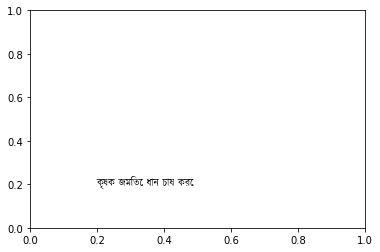

In [37]:
# for testing

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

prop = fm.FontProperties(fname='kalpurush.ttf')
s = "কৃষক জমিতে ধান চাষ করে"
x = 0.2
y = 0.2
plt.text(x, y, s, fontproperties=prop)
plt.show()

In [38]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

#banglar jonno kon font bhalo hoy oita thik korte hobe
seaborn.set(font=['kalpurush.ttf'], font_scale=3)

def attent_and_generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, katakana = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = seaborn.heatmap(attention_density[:len(katakana) + 2, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in katakana])

    ax.invert_yaxis()
    plt.show()


C:\Users\RANA_CSE\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['kalpurush.ttf'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


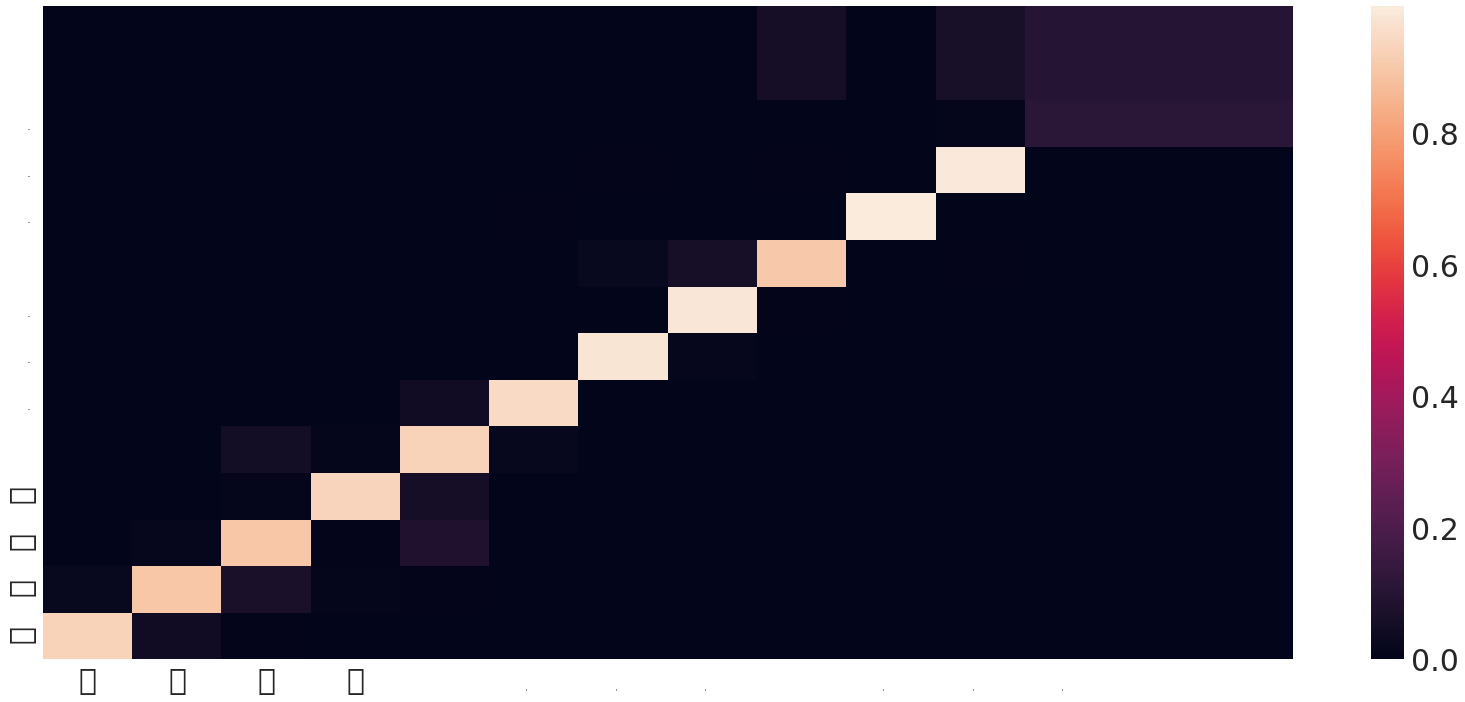

In [39]:
visualize('সাদা লাল নীল')

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


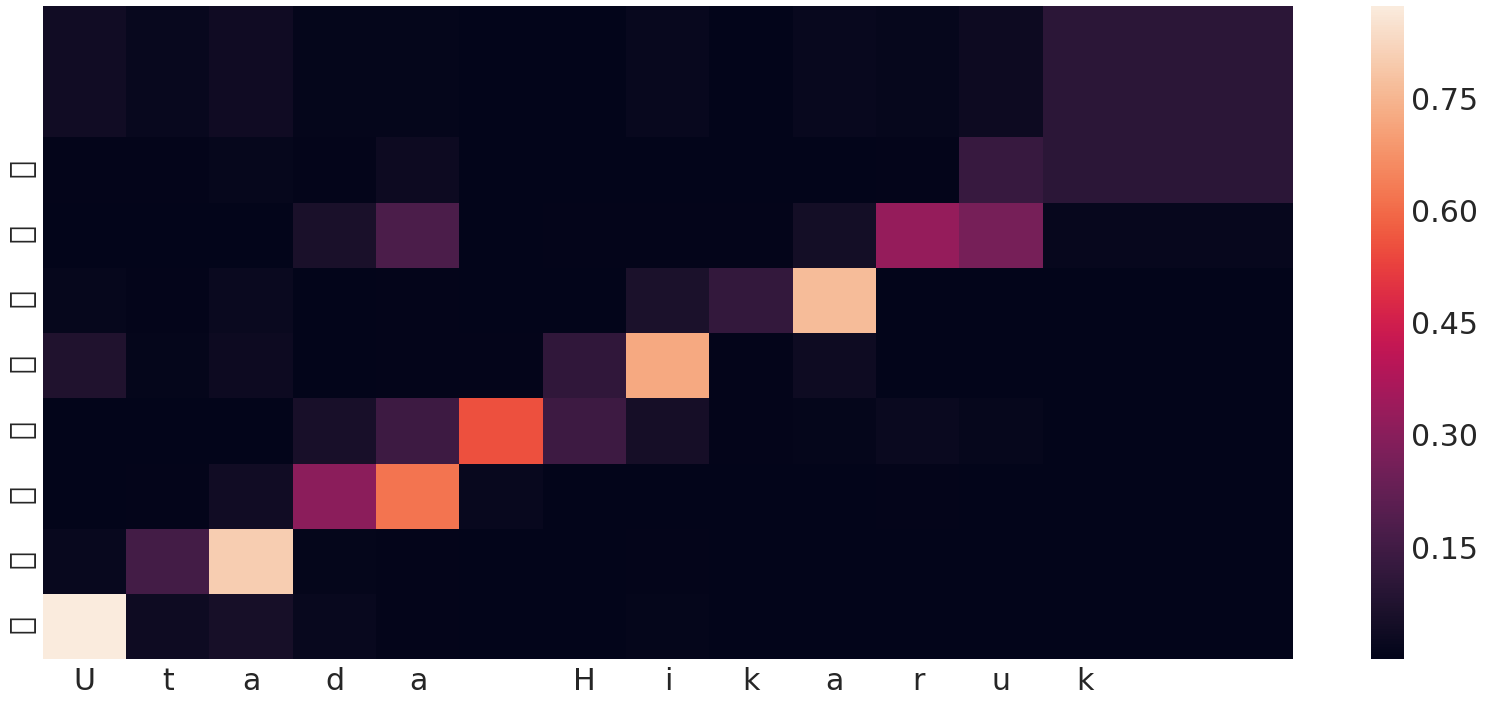

In [23]:
visualize('Utada Hikaruk')

In [11]:
visualize('Harry Potter')

NameError: name 'visualize' is not defined

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


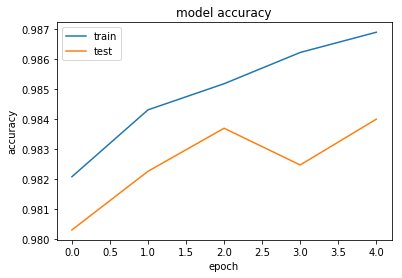

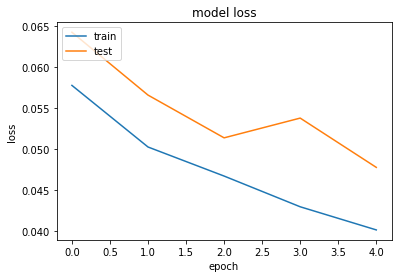

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()